# <B> Anormaly Detection based on AutoEncoder </B>
* Container: codna_pytorch_p39

## AutoEncoder based anomaly detection

- **RaPP** - Novelty Detection with Reconstruction along Projection Pathway <br>
<p align="center">
    <img src="imgs/rapp-f1.png" width="1100" height="300" style="display: block; margin: 0 auto"/>
</p>
<p align="center">
    <img src="imgs/rapp-f2.png" width="1100" height="300" style="display: block; margin: 0 auto"/>
</p>

    * [Ppaer, ICLR 2020] https://openreview.net/attachment?id=HkgeGeBYDB&name=original_pdf
    * [Desc, KOREAN] [RaPP](https://makinarocks.github.io/rapp/)
    * [Supplement #1] [Autoencoder based Anomaly Detection](https://makinarocks.github.io/Autoencoder-based-anomaly-detection/)
    * [Supplement #2] [Reference code (github)](https://github.com/Aiden-Jeon/RaPP)
        

## AutoReload

In [1]:
%load_ext autoreload
%autoreload 2

## parameter store 설정

In [2]:
import boto3
from utils.ssm import parameter_store

In [3]:
strRegionName=boto3.Session().region_name
pm = parameter_store(strRegionName)
strPrefix = pm.get_params(key="PREFIX")

## pramamters for tasks

In [4]:
strAccountId = pm.get_params(key="-".join([strPrefix, "ACCOUNT-ID"]))
strBucketName = pm.get_params(key="-".join([strPrefix, "BUCKET"]))
strExecutionRole = pm.get_params(key="-".join([strPrefix, "SAGEMAKER-ROLE-ARN"]))
strS3DataPath = pm.get_params(key="-".join([strPrefix, "S3-DATA-PATH"]))

In [5]:
print (f"prefix: {strPrefix}")
print (f"account_id: {strAccountId}")
print (f"defaulut_bucket: {strBucketName}")
print (f"sagemaker_role: {strExecutionRole}")
print (f"s3_data_path: {strS3DataPath}")

prefix: ad-ts
account_id: 419974056037
defaulut_bucket: sm-anomaly-detection-dongjin
sagemaker_role: arn:aws:iam::419974056037:role/service-role/AmazonSageMaker-ExecutionRole-20221206T163436
s3_data_path: s3://sm-anomaly-detection-dongjin/data


## 1. Data manipulation and visualization

In [6]:
import os
import pandas as pd
from utils.util import plot_click_w_fault_and_res, plot_click_w_fault_res_ad, plot_click_w_ad_exp

* load data and derive features

In [7]:
clicks_1T = pd.read_csv(os.path.join(strS3DataPath, "clicks_1T.csv"), parse_dates=["timestamp"]).set_index("timestamp")
clicks_1T["residual"] = clicks_1T['click'] - clicks_1T['user'] 
clicks_1T["fault"] = pd.read_csv(os.path.join(strS3DataPath, "fault_label_1T.csv"), header=None).values[0] ## label
clicks_1T["time"] = [int(str(time).split(" ")[1].split(":")[0]) for time in clicks_1T.index] ## time variable

In [8]:
print (f'data shape: {clicks_1T.shape}')
print (f'timestamp min: {clicks_1T.index.min()}, max: {clicks_1T.index.max()}')

data shape: (12960, 6)
timestamp min: 2020-07-07 00:00:00, max: 2020-07-15 23:59:00


* visualization

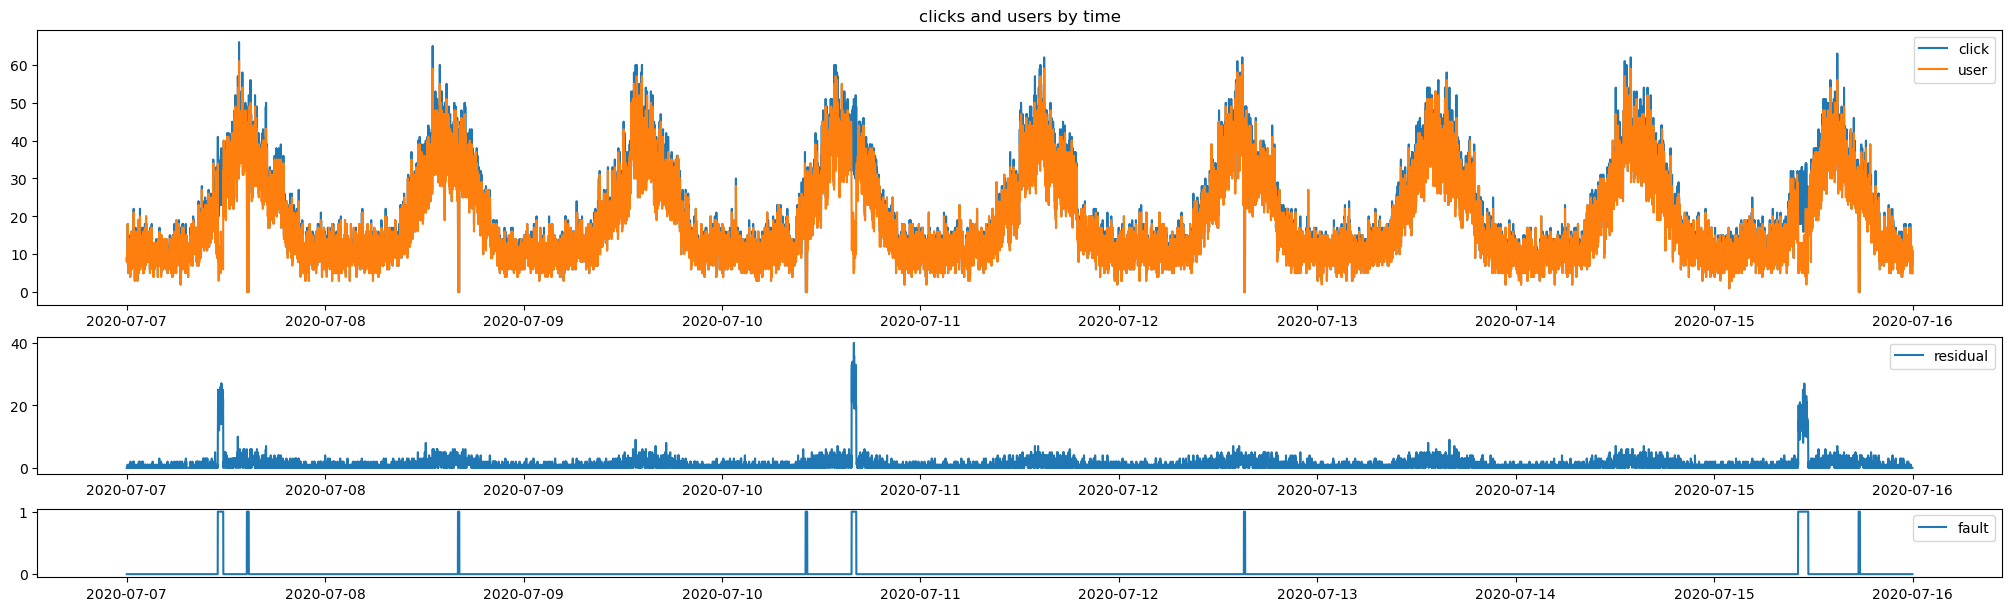

In [9]:
plot_click_w_fault_and_res(clicks_1T)

* upload data to s3 and local

In [10]:
strTrainDataName = "merged_clicks_1T.csv"
clicks_1T.to_csv(os.path.join(strS3DataPath, strTrainDataName), index=True) # to s3
clicks_1T.to_csv(os.path.join("./data", strTrainDataName), index=True) # to local

print (f'train_data_name: {strTrainDataName}')

train_data_name: merged_clicks_1T.csv


## 2. Processing-job for preprocessing

In [11]:
import os
import sagemaker
from sagemaker.pytorch.estimator import PyTorch
from sagemaker.processing import ProcessingInput, ProcessingOutput, FrameworkProcessor

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/base_serializers.py:28: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 1.23.4)
  import scipy.sparse


[01/13/25 12:44:36] INFO     Found credentials from IAM Role:                                   ]8;id=137232;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=187980;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


* params for processing job

In [12]:
local_mode = True

if local_mode: 
    strInstanceType = 'local_gpu'
    
    import os
    from sagemaker.local import LocalSession
    
    sagemaker_session = LocalSession()
    strDataPath = str(os.path.join("file://", os.getcwd(), "data"))
    
else:
    strInstanceType = "ml.m5.xlarge"
    sagemaker_session = sagemaker.Session()
    strDataPath = strS3DataPath
        
print (f"instance-type: {strInstanceType}")
print (f'role: {strExecutionRole}')
print (f"bucket: {strBucketName}")
print (f"dataset-path: {strDataPath}")
print (f"sagemaker_session: {sagemaker_session}")

[01/13/25 12:44:37] INFO     Found credentials from IAM Role:                                   ]8;id=101161;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=637461;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

instance-type: local_gpu
role: arn:aws:iam::419974056037:role/service-role/AmazonSageMaker-ExecutionRole-20221206T163436
bucket: sm-anomaly-detection-dongjin
dataset-path: /home/ec2-user/SageMaker/aws-ai-ml-workshop-kr/sagemaker/sm-scale-down-to-zero/data
sagemaker_session: <sagemaker.local.local_session.LocalSession object at 0x7f3cf8561930>


* Define processing job

In [13]:
dataset_processor = FrameworkProcessor(
    estimator_cls=PyTorch,
    framework_version="2.0.0",
    py_version="py310",
    image_uri=None,
    instance_type=strInstanceType,
    instance_count=1,
    role=strExecutionRole,
    base_job_name="preprocessing", # bucket에 보이는 이름 (pipeline으로 묶으면 pipeline에서 정의한 이름으로 bucket에 보임)
    sagemaker_session=sagemaker_session
)

strProcPrefix = "/opt/ml/processing"

strOutputPath = os.path.join(
    "s3://{}".format(strBucketName),
    strPrefix,
    "preprocessing",
    "output"
)

nShingleSize = 4

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=908971;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=519589;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

In [14]:
print (f'strOutputPath: {strOutputPath}')
print (f'nShingleSize: {nShingleSize}')

strOutputPath: s3://sm-anomaly-detection-dongjin/ad-ts/preprocessing/output
nShingleSize: 4


In [15]:
dataset_processor.run(
    #job_name="preprocessing", ## 이걸 넣어야 캐시가 작동함, 안그러면 프로세서의 base_job_name 이름뒤에 날짜 시간이 붙어서 캐시 동작 안함
    #git_config=git_config,
    code='preprocessing.py', #소스 디렉토리 안에서 파일 path
    source_dir= "./src/preprocessing", #현재 파일에서 소스 디렉토리 상대경로 # add processing.py and requirements.txt here
    inputs=[
        ProcessingInput(
            input_name="input-data",
            source=strDataPath,
            destination=os.path.join(strProcPrefix, "input")
        ),
    ],
    outputs=[       
        ProcessingOutput(
            output_name="output-data",
            source=os.path.join(strProcPrefix, "output"),
            destination=strOutputPath
        ),
    ],
    arguments=[
        "--proc_prefix", strProcPrefix, \
        "--shingle_size", str(nShingleSize), \
        "--train_data_name", strTrainDataName
    ]
)

                    INFO     Uploaded ./src/preprocessing to                                     ]8;id=252892;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=254474;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/processing.py#1961\1961]8;;\
                             s3://sagemaker-us-west-2-419974056037/preprocessing-2025-01-13-12-4                   
                             4-37-424/source/sourcedir.tar.gz                                                      

                    INFO     runproc.sh uploaded to                                              ]8;id=321664;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/processing.py\processing.py]8;;\:]8;id=390032;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/processing.py#2055\2055]8;;\
                             s3://sagemaker-us-west-2-419974056037/preprocessing-2025-01-13-12-4                   
                             4-37-424/source/runproc.sh                                                            

[01/13/25 12:44:39] INFO     Creating processing-job with name                                      ]8;id=330682;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=299681;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#1575\1575]8;;\
                             preprocessing-2025-01-13-12-44-37-424                                                 

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=966138;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=44545;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     'Docker Compose' is not installed. Proceeding to check for                ]8;id=332703;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py\image.py]8;;\:]8;id=127921;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py#162\162]8;;\
                             'docker-compose' CLI.                                                                 

                    INFO     'Docker Compose' found using Docker Compose CLI.                          ]8;id=767974;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py\image.py]8;;\:]8;id=335328;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py#173\173]8;;\

                    INFO     Starting processing job                                           ]8;id=300846;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/local_session.py\local_session.py]8;;\:]8;id=853918;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/local_session.py#144\144]8;;\

[01/13/25 12:44:40] INFO     Found credentials from IAM Role:                                   ]8;id=703059;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=627733;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     No AWS credentials found in session but credentials from EC2 Metadata    ]8;id=699657;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py\image.py]8;;\:]8;id=287756;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py#1131\1131]8;;\
                             Service are available.                                                                

                    INFO     docker compose file:                                                      ]8;id=56345;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py\image.py]8;;\:]8;id=620862;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py#771\771]8;;\
                             networks:                                                                             
                               sagemaker-local:                                                                    
                                 name: sagemaker-local                                                             
                             services:                                                                             
                               algo-1-ir34k:                                                                       
                                 container_name: 0w9kcpadz7-algo-1-ir34k                                           
                                 deploy:                                                                           
                                   resources:                                                                      
                                     reservations:                                                                 
                                       devices:                                                                    
                                       - capabilities:                                                             
                                         - gpu                                                                     
                                         count: all                                                                
                                 entrypoint:                                                                       
                                 - /bin/bash                                                                       
                                 - /opt/ml/processing/input/entrypoint/runproc.sh                                  
                                 - --proc_prefix                                                                   
                                 - /opt/ml/processing                                                              
                                 - --shingle_size                                                                  
                                 - '4'                                                                             
                                 - --train_data_name                                                               
                                 - merged_clicks_1T.csv                                                            
                                 environment: []                                                                   
                                 image:                                                                            
                             763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-training:2.0.0-gpu-p             
                             y310                                                                                  
                                 networks:                                                                         
                                   sagemaker-local:                                                                
                                     aliases:                                                                      
                                     - algo-1-ir34k                                                                
                                 stdin_open: true                                                                  
                                 

                    INFO     docker command: docker-compose -f /tmp/tmpisv7ig_l/docker-compose.yaml up ]8;id=971733;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py\image.py]8;;\:]8;id=238323;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py#795\795]8;;\
                             --build --abort-on-container-exit                                                     

time="2025-01-13T12:44:40Z" level=warning msg="/tmp/tmpisv7ig_l/docker-compose.yaml: `version` is obsolete"
time="2025-01-13T12:44:40Z" level=warning msg="a network with name sagemaker-local exists but was not created for project \"tmpisv7ig_l\".\nSet `external: true` to use an existing network"
 Container 0w9kcpadz7-algo-1-ir34k  Creating
 Container 0w9kcpadz7-algo-1-ir34k  Created
Attaching to 0w9kcpadz7-algo-1-ir34k
0w9kcpadz7-algo-1-ir34k  | CodeArtifact repository not specified. Skipping login.
0w9kcpadz7-algo-1-ir34k  | WARNING: Skipping typing as it is not installed.
0w9kcpadz7-algo-1-ir34k  | WARNING: Running pip as the 'root' user can result in broken permissions and conflicting behaviour with the system package manager. It is recommended to use a virtual environment instead: https://pip.pypa.io/warnings/venv
0w9kcpadz7-algo-1-ir34k  | Collecting mlflow==2.13.2 (from -r requirements.txt (line 1))
0w9kcpadz7-algo-1-ir34k  |   Downloading mlflow-2.13.2-py3-none-any.whl (25.0 MB)

[01/13/25 12:44:55] WARNING  Failed to delete: /tmp/tmpgcilci_g/output/output-data Please remove it     ]8;id=729319;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/utils.py\utils.py]8;;\:]8;id=920224;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/utils.py#95\95]8;;\
                             manually.                                                                             

                    WARNING  Failed to delete: /tmp/tmpgcilci_g Please remove it manually.            ]8;id=437667;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py\image.py]8;;\:]8;id=662150;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py#1087\1087]8;;\

                    INFO     ===== Job Complete =====                                                  ]8;id=505736;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py\image.py]8;;\:]8;id=635005;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py#250\250]8;;\

* download preprocessed data to local

In [16]:
!aws s3 sync $strOutputPath ./data/preprocessing --quiet

* save params

In [17]:
pm.put_params(key="-".join([strPrefix, "PREP-DATA-PATH"]), value=strOutputPath, overwrite=True)
print (f'S3-PREP-DATA-PATH: {pm.get_params(key="-".join([strPrefix, "PREP-DATA-PATH"]))}')

S3-PREP-DATA-PATH: s3://sm-anomaly-detection-dongjin/ad-ts/preprocessing/output


## 3. Training-job for anomaly detection

* check gpu

In [18]:
import torch

In [19]:
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"# DEVICE {i}: {torch.cuda.get_device_name(i)}")
        print("- Memory Usage:")
        print(f"  Allocated: {round(torch.cuda.memory_allocated(i)/1024**3,1)} GB")
        print(f"  Cached:    {round(torch.cuda.memory_reserved(i)/1024**3,1)} GB\n")
        
else:
    print("# GPU is not available")
    
# GPU 할당 변경하기
GPU_NUM = 0 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU

print ('# Current cuda device: ', torch.cuda.current_device()) # check

# DEVICE 0: NVIDIA A10G
- Memory Usage:
  Allocated: 0.0 GB
  Cached:    0.0 GB

# Current cuda device:  0


In [20]:
import os
from sagemaker.pytorch.estimator import PyTorch
from sagemaker.inputs import TrainingInput

* **Set Up SageMaker Experiment**
    - Create or load [SageMaker Experiment](https://docs.aws.amazon.com/sagemaker/latest/dg/experiments.html) for the example training job. This will create an experiment trial object in SageMaker.
    - **pip instatll sagemaker-experiments**

In [21]:
from time import strftime

* params for training job

In [22]:
# Set to True to enable SageMaker to run locally
local_mode = True

if local_mode:
    strInstanceType = "local_gpu"
    
    import os
    from sagemaker.local import LocalSession
    
    sagemaker_session = LocalSession()
    sagemaker_session.config = {'local': {'local_code': True}}
    
    strLocalDataDir = os.getcwd() + '/data/preprocessing'
    dicDataChannels = {
        "train": f"file://{strLocalDataDir}",
        "validation": f"file://{strLocalDataDir}"
    }
    
else:
    
    strInstanceType = "ml.g4dn.2xlarge" #"ml.p3.2xlarge"#"ml.g4dn.8xlarge"#"ml.p3.2xlarge", 'ml.p3.16xlarge' , ml.g4dn.8xlarge
    
    sagemaker_session = sagemaker.Session()
    dicDataChannels = {
        "train": pm.get_params(key="-".join([strPrefix, "PREP-DATA-PATH"])),
        "validation": pm.get_params(key="-".join([strPrefix, "PREP-DATA-PATH"]))
    }

dicHyperParams = {
    "epochs":"150",
    "batch_size":"128", 
    "lr":"1e-2",
    "shingle_size":"4",
    "num_features":"4",
    "emb_size":"4",
    "workers":"2"
}

nInstanceCount = 1

bSpotTraining = False
if bSpotTraining:
    nMaxWait = 1*60*60
    nMaxRun = 1*60*60
    
else:
    nMaxWait = None
    nMaxRun = 1*60*60

bUseTrainWarmPool = False ## training image 다운받지 않음, 속도 빨라진다
if bUseTrainWarmPool: nKeepAliveSeconds = 3600 ## 최대 1시간 동안!!, service quota에서 warmpool을 위한 request 필요
else: nKeepAliveSeconds = None
if bSpotTraining:
    bUseTrainWarmPool = False # warmpool은 spot instance 사용시 활용 할 수 없음
    nKeepAliveSeconds = None
    
    
strProcPrefix = "/opt/ml/processing"

strOutputPath = os.path.join(
    "s3://{}".format(strBucketName),
    strPrefix,
    "training",
    "model-output"
)

strCodeLocation = os.path.join(
    "s3://{}".format(strBucketName),
    strPrefix,
    "training",
    "backup_codes"
)

strExperimentName = '-'.join([strPrefix, "experiments"])

num_re = "([0-9\\.]+)(e-?[[01][0-9])?"
metric_definitions = [
    {"Name": "Train loss", "Regex": f"loss={num_re}"},
    {"Name": "Train cos", "Regex": f"wer:{num_re}"},
    {"Name": "Val cos", "Regex": f"wer:{num_re}"}
]

kwargs = {}

[01/13/25 12:44:57] INFO     Found credentials from IAM Role:                                   ]8;id=243802;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=692872;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [23]:
print (f'local_mode: {local_mode}')
print (f'sagemaker_session: {sagemaker_session}')
print (f'strInstanceType: {strInstanceType}')
print (f'dicDataChannels: {dicDataChannels}')
print (f'strOutputPath: {strOutputPath}')

local_mode: True
sagemaker_session: <sagemaker.local.local_session.LocalSession object at 0x7f3cb8fd74c0>
strInstanceType: local_gpu
dicDataChannels: {'train': 'file:///home/ec2-user/SageMaker/aws-ai-ml-workshop-kr/sagemaker/sm-scale-down-to-zero/data/preprocessing', 'validation': 'file:///home/ec2-user/SageMaker/aws-ai-ml-workshop-kr/sagemaker/sm-scale-down-to-zero/data/preprocessing'}
strOutputPath: s3://sm-anomaly-detection-dongjin/ad-ts/training/model-output


* Define training job

In [24]:
estimator = PyTorch(
    entry_point="main.py", # the script we want to run
    source_dir="./src/training", # where our conf/script is
    #git_config=git_config,
    role=strExecutionRole,
    instance_type=strInstanceType,
    instance_count=nInstanceCount,
    image_uri=None,
    framework_version="2.0.0",#"1.13.1", # version of PyTorch
    py_version="py310",#"py39",
    volume_size=256,
    code_location = strCodeLocation,
    output_path=strOutputPath,
    disable_profiler=True,
    debugger_hook_config=False,
    hyperparameters=dicHyperParams, #{'config-path': 'conf'},
    #distribution={"smdistributed":{"dataparallel":{"enabled":True, "fp16": True}}},
    sagemaker_session=sagemaker_session,
    metric_definitions=metric_definitions,
    max_run=nMaxRun,
    use_spot_instances=bSpotTraining,  # spot instance 활용
    max_wait=nMaxWait,
    keep_alive_period_in_seconds=nKeepAliveSeconds,
    enable_sagemaker_metrics=True,
    **kwargs
)

In [25]:
experiment_name = "AD"
create_date = strftime("%m%d-%H%M%s")
job_name=f'{experiment_name}-{create_date}'
job_name

'AD-0113-12441736772298'

In [26]:
if strInstanceType =='local_gpu': estimator.checkpoint_s3_uri = None

estimator.fit(
    inputs=dicDataChannels, 
    job_name=job_name,
    experiment_config={
      'TrialName': job_name,
      'TrialComponentDisplayName': job_name,
    },
    wait=True,
)

[01/13/25 12:44:58] INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=469186;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=246373;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     image_uri is not presented, retrieving image_uri based on            ]8;id=44561;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=609696;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/image_uris.py#679\679]8;;\
                             instance_type, framework etc.                                                         

                    INFO     Creating training-job with name: AD-0113-12441736772298                ]8;id=415987;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=662703;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=471381;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=277583;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/telemetry/telemetry_logging.py#90\90]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     'Docker Compose' is not installed. Proceeding to check for                ]8;id=701228;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py\image.py]8;;\:]8;id=725997;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py#162\162]8;;\
                             'docker-compose' CLI.                                                                 

                    INFO     'Docker Compose' found using Docker Compose CLI.                          ]8;id=287171;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py\image.py]8;;\:]8;id=355845;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py#173\173]8;;\

                    INFO     Starting training job                                             ]8;id=167043;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/local_session.py\local_session.py]8;;\:]8;id=782829;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/local_session.py#215\215]8;;\

                    INFO     Found credentials from IAM Role:                                   ]8;id=78647;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=480928;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     No AWS credentials found in session but credentials from EC2 Metadata    ]8;id=694843;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py\image.py]8;;\:]8;id=699195;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py#1131\1131]8;;\
                             Service are available.                                                                

                    INFO     docker compose file:                                                      ]8;id=937;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py\image.py]8;;\:]8;id=310496;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py#771\771]8;;\
                             networks:                                                                             
                               sagemaker-local:                                                                    
                                 name: sagemaker-local                                                             
                             services:                                                                             
                               algo-1-qyqvo:                                                                       
                                 command: train                                                                    
                                 container_name: b6dw81mv0s-algo-1-qyqvo                                           
                                 deploy:                                                                           
                                   resources:                                                                      
                                     reservations:                                                                 
                                       devices:                                                                    
                                       - capabilities:                                                             
                                         - gpu                                                                     
                                         count: all                                                                
                                 environment:                                                                      
                                 - '[Masked]'                                                                      
                                 - '[Masked]'                                                                      
                                 - '[Masked]'                                                                      
                                 image:                                                                            
                             763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-training:2.0.0-gpu-p             
                             y310                                                                                  
                                 networks:                                                                         
                                   sagemaker-local:                                                                
                                     aliases:                                                                      
                                     - algo-1-qyqvo                                                                
                                 stdin_open: true                                                                  
                                 tty: true                                                                         
                                 volumes:                                                                          
                                 - /tmp/tmpuxzpzab4/algo-1-qyqvo/input:/opt/ml/input                               
                                 - /tmp/tmpuxzpzab4/algo-1-qyqvo/output:/opt/ml/output                             
                                 - /tmp/tmpuxzpzab4/algo-1-qyqvo/output/data:/opt/ml/output/data                   
                                 - 

                    INFO     docker command: docker-compose -f /tmp/tmpuxzpzab4/docker-compose.yaml up ]8;id=451313;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py\image.py]8;;\:]8;id=928862;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py#795\795]8;;\
                             --build --abort-on-container-exit                                                     

time="2025-01-13T12:44:58Z" level=warning msg="/tmp/tmpuxzpzab4/docker-compose.yaml: `version` is obsolete"
time="2025-01-13T12:44:58Z" level=warning msg="a network with name sagemaker-local exists but was not created for project \"tmpuxzpzab4\".\nSet `external: true` to use an existing network"
 Container b6dw81mv0s-algo-1-qyqvo  Creating
 Container b6dw81mv0s-algo-1-qyqvo  Created
Attaching to b6dw81mv0s-algo-1-qyqvo
b6dw81mv0s-algo-1-qyqvo  | 2025-01-13 12:44:58,889 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
b6dw81mv0s-algo-1-qyqvo  | 2025-01-13 12:44:58,910 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
b6dw81mv0s-algo-1-qyqvo  | 2025-01-13 12:44:58,918 sagemaker-training-toolkit INFO     instance_groups entry not present in resource_config
b6dw81mv0s-algo-1-qyqvo  | 2025-01-13 12:44:58,920 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
b6dw81mv0s-algo

[01/13/25 12:46:46] INFO     ===== Job Complete =====                                                  ]8;id=214828;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py\image.py]8;;\:]8;id=175165;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sagemaker/local/image.py#325\325]8;;\

In [27]:
print (f'model data: {estimator.model_data}')

model data: s3://sm-anomaly-detection-dongjin/ad-ts/training/model-output/AD-0113-12441736772298/output/model.tar.gz


* save params

In [28]:
pm.put_params(key="-".join([strPrefix, "S3-MODEL-ARTIFACT"]), value=estimator.model_data, overwrite=True)
print (f'S3-MODEL-ARTIFACT: {pm.get_params(key="-".join([strPrefix, "S3-MODEL-ARTIFACT"]))}')

S3-MODEL-ARTIFACT: s3://sm-anomaly-detection-dongjin/ad-ts/training/model-output/AD-0113-12441736772298/output/model.tar.gz


## 4. Deploy

### Create model

In [29]:
import boto3
from sagemaker.utils import name_from_base

In [30]:
sm_client = boto3.client('sagemaker')

- restructured dir

In [ ]:
# - Set directory structure
# '''
# model
# |----- best_model.pth
# |----- code
#         |----- inference.py
#         |----- test.py
# '''

In [31]:
src = "./src/deploy"
model_data_path = pm.get_params(key="-".join([strPrefix, "S3-MODEL-ARTIFACT"]))

is_ckpt = False
if "model.tar.gz" not in model_data_path: is_ckpt = True
if not is_ckpt: model_data_path = model_data_path.replace("model.tar.gz", "")

print (model_data_path)

model_tmp_dir = "./model"
model_destination = os.path.join(
    "s3://{}".format(strBucketName),
    strPrefix,
    "training",
    "model-output",
    "restructurd-model"
)

!aws s3 sync $model_data_path $model_tmp_dir
!tar -zxvf $model_tmp_dir/model.tar.gz -C $model_tmp_dir/ 
!rm -rf $model_tmp_dir/model.tar.gz
!rm -rf $model_tmp_dir/output.tar.gz
!cp -r $src $model_tmp_dir/code

!tar -zcvf ./model.tar.gz -C $model_tmp_dir .
!aws s3 cp ./model.tar.gz $model_destination/model.tar.gz
!rm -rf ./model.tar.gz

s3_code_artifact = os.path.join(model_destination, "model.tar.gz")

s3://sm-anomaly-detection-dongjin/ad-ts/training/model-output/AD-0113-12441736772298/output/
download: s3://sm-anomaly-detection-dongjin/ad-ts/training/model-output/AD-0113-12441736772298/output/output.tar.gz to model/output.tar.gz
download: s3://sm-anomaly-detection-dongjin/ad-ts/training/model-output/AD-0113-12441736772298/output/model.tar.gz to model/model.tar.gz
best_model.pth
./
./code/
./code/_repack_model.py
./code/inference.py
./code/_repack_script_launcher.sh
./code/autoencoder.py
./code/deploy.py
./code/deploy/
./code/deploy/_repack_model.py
./code/deploy/inference.py
./code/deploy/_repack_script_launcher.sh
./code/deploy/autoencoder.py
./code/deploy/deploy.py
./code/deploy/requirements.txt
./code/requirements.txt
./.ipynb_checkpoints/
./best_model.pth
upload: ./model.tar.gz to s3://sm-anomaly-detection-dongjin/ad-ts/training/model-output/restructurd-model/model.tar.gz


- Create model

In [32]:
image_uri = sagemaker.image_uris.retrieve(
    framework='pytorch',
    region=strRegionName,
     image_scope="inference",
    version='2.0.0',
    py_version='py310',
    instance_type="ml.g4dn.xlarge"
)
image_uri

'763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-inference:2.0.0-gpu-py310'

In [33]:
model_name = name_from_base(strPrefix)
print(model_name)

create_model_response = sm_client.create_model(
    ModelName=model_name,
    ExecutionRoleArn=strExecutionRole,
    PrimaryContainer={
        "Image": image_uri,
        "ModelDataUrl": s3_code_artifact,
        'Environment': {
            'SAGEMAKER_PROGRAM': 'inference.py',
            'SAGEMAKER_SUBMIT_DIRECTORY': '/opt/ml/model/code',
            'SAGEMAKER_CONTAINER_LOG_LEVEL': '20',
            'SAGEMAKER_REGION': strRegionName,
            'MODEL_SERVER_WORKERS': '1'
        }
    },
)
model_arn = create_model_response["ModelArn"]

print(f"Created Model: {model_arn}")

ad-ts-2025-01-13-12-46-50-328
Created Model: arn:aws:sagemaker:us-west-2:419974056037:model/ad-ts-2025-01-13-12-46-50-328


In [ ]:
model_name = model_arn.rsplit('/', 1)[-1]

- create_endpoint_config

In [34]:
# Set an unique endpoint config name
endpoint_config_name = f"{strPrefix}-endpoint-config"
print(f"Demo endpoint config name: {endpoint_config_name}")

# Set varient name and instance type for hosting
variant_name = "AllTraffic"
instance_type = "ml.g5.xlarge"
model_data_download_timeout_in_seconds = 3600
container_startup_health_check_timeout_in_seconds = 3600

#################
initial_instance_count = 0 ## Scale down to Zero
#################

max_instance_count = 3
print(f"Initial instance count: {initial_instance_count}")
print(f"Max instance count: {max_instance_count}")

sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ExecutionRoleArn=strExecutionRole,
    ProductionVariants=[
        {
            "VariantName": variant_name,
            "InstanceType": instance_type,
            "InitialInstanceCount": 1,
            "ModelDataDownloadTimeoutInSeconds": model_data_download_timeout_in_seconds,
            "ContainerStartupHealthCheckTimeoutInSeconds": container_startup_health_check_timeout_in_seconds,
            "ManagedInstanceScaling": {
                "Status": "ENABLED",
                "MinInstanceCount": initial_instance_count,
                "MaxInstanceCount": max_instance_count,
            },
            "RoutingConfig": {"RoutingStrategy": "LEAST_OUTSTANDING_REQUESTS"},
        }
    ],
)


Demo endpoint config name: ad-ts-endpoint-config
Initial instance count: 0
Max instance count: 3


{'EndpointConfigArn': 'arn:aws:sagemaker:us-west-2:419974056037:endpoint-config/ad-ts-endpoint-config',
 'ResponseMetadata': {'RequestId': 'ac386056-5b13-4a17-8323-1de6c1de6cef',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'ac386056-5b13-4a17-8323-1de6c1de6cef',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '102',
   'date': 'Mon, 13 Jan 2025 12:46:50 GMT'},
  'RetryAttempts': 0}}

- create_endpoint

In [35]:
# Set a unique endpoint name
sagemaker_session = sagemaker.Session()
endpoint_name = f"{strPrefix}-endpoint"
print(f"Demo endpoint name: {endpoint_name}")

sm_client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name,
)

Demo endpoint name: ad-ts-endpoint


{'EndpointArn': 'arn:aws:sagemaker:us-west-2:419974056037:endpoint/ad-ts-endpoint',
 'ResponseMetadata': {'RequestId': 'a2cf9273-ea8e-4f88-8b18-2c580b1bf2be',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'a2cf9273-ea8e-4f88-8b18-2c580b1bf2be',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '82',
   'date': 'Mon, 13 Jan 2025 12:46:51 GMT'},
  'RetryAttempts': 0}}

In [36]:
sagemaker_session.wait_for_endpoint(endpoint_name)

----!

{'EndpointName': 'ad-ts-endpoint',
 'EndpointArn': 'arn:aws:sagemaker:us-west-2:419974056037:endpoint/ad-ts-endpoint',
 'EndpointConfigName': 'ad-ts-endpoint-config',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'CurrentInstanceCount': 1,
   'DesiredInstanceCount': 1,
   'ManagedInstanceScaling': {'Status': 'ENABLED',
    'MinInstanceCount': 0,
    'MaxInstanceCount': 3},
   'RoutingConfig': {'RoutingStrategy': 'LEAST_OUTSTANDING_REQUESTS'}}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2025, 1, 13, 12, 46, 51, 702000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2025, 1, 13, 12, 49, 10, 234000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '486a165a-fd8b-47f8-b4ee-82b34172bb04',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '486a165a-fd8b-47f8-b4ee-82b34172bb04',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '511',
   'date': 'Mon, 13 Jan 2025 12:49:21 GMT'},
  'RetryAttempts': 0}}

- create_inference_component

In [37]:
inference_component_name = f"{strPrefix}-inference-component"
print(f"Demo inference component name: {inference_component_name}:: endpoint_name={endpoint_name}")
variant_name = "AllTraffic"

Demo inference component name: ad-ts-inference-component:: endpoint_name=ad-ts-endpoint


In [38]:
sm_client.create_inference_component(
    InferenceComponentName=inference_component_name,
    EndpointName=endpoint_name,
    VariantName=variant_name,
    Specification={
        "ModelName": model_name,
        "StartupParameters": {
            "ModelDataDownloadTimeoutInSeconds": 300,
            "ContainerStartupHealthCheckTimeoutInSeconds": 600,
        },
        "ComputeResourceRequirements": {
            "NumberOfAcceleratorDevicesRequired": 1,
            "MinMemoryRequiredInMb": 1024,
        },
    },
    RuntimeConfig={"CopyCount": 1},
)

{'InferenceComponentArn': 'arn:aws:sagemaker:us-west-2:419974056037:inference-component/ad-ts-inference-component',
 'ResponseMetadata': {'RequestId': '323a8c85-44cc-4877-ac0a-65acc36e75c9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '323a8c85-44cc-4877-ac0a-65acc36e75c9',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '114',
   'date': 'Mon, 13 Jan 2025 12:49:22 GMT'},
  'RetryAttempts': 0}}

In [39]:
import sys, time

while True:
    desc = sm_client.describe_inference_component(
        InferenceComponentName=inference_component_name
    )
    status = desc["InferenceComponentStatus"]
    print(status)
    sys.stdout.flush()
    if status in ["InService", "Failed"]:
        break
    time.sleep(30)
    
desc = sm_client.describe_inference_component(InferenceComponentName=inference_component_name)
print(desc)

Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
InService
{'InferenceComponentName': 'ad-ts-inference-component', 'InferenceComponentArn': 'arn:aws:sagemaker:us-west-2:419974056037:inference-component/ad-ts-inference-component', 'EndpointName': 'ad-ts-endpoint', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:419974056037:endpoint/ad-ts-endpoint', 'VariantName': 'AllTraffic', 'Specification': {'ModelName': 'ad-ts-2025-01-13-12-46-50-328', 'StartupParameters': {'ModelDataDownloadTimeoutInSeconds': 300, 'ContainerStartupHealthCheckTimeoutInSeconds': 600}, 'ComputeResourceRequirements': {'NumberOfAcceleratorDevicesRequired': 1.0, 'MinMemoryRequiredInMb': 1024}}, 'RuntimeConfig': {'DesiredCopyCount': 1, 'CurrentCopyCount': 1}, 'CreationTime': datetime.datetime(2025, 1, 13, 12, 49, 22, 596000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2025, 1, 13, 12, 55, 35, 793000, tzinfo=tzlocal()), 'InferenceComponentStatus'

In [40]:
inference_component_name

'ad-ts-inference-component'

## 5. Inference (invocation)

In [41]:
import boto3
import json
import pickle

In [42]:
sagemaker_runtime_client = boto3.Session().client('sagemaker-runtime')

[01/13/25 12:55:55] INFO     Found credentials from IAM Role:                                   ]8;id=860812;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=223307;file:///home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/credentials.py#1075\1075]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [43]:
def from_pickle(obj_path):
    with open(file=obj_path, mode="rb") as f:
        obj=pickle.load(f)
    return obj

In [44]:
data_path = "./data/preprocessing/data_x_scaled_shingle.pkl"
data = from_pickle(data_path)
data = data[4, :]
dtype = data.dtype
shape = data.shape

In [45]:
print (f'data: {data}')
print (f'dtype: {dtype}')
print (f'shape: {shape}')

data: [ 0.         -1.2944116  -0.9026603  -0.51090899 -0.11915769 -0.88238043
 -0.88238043 -0.43300718 -0.07350859 -0.92357365 -0.92357365 -0.41631919
 -0.16269195 -0.47232556 -0.47232556 -0.04545392 -0.47232556]
dtype: float64
shape: (17,)


In [46]:
payload={"INPUT": data.tolist(), "SHAPE":shape, "DTYPE": str(dtype)}

In [47]:
response_model = sagemaker_runtime_client.invoke_endpoint(
    InferenceComponentName=inference_component_name,
    EndpointName=endpoint_name,
    Body=json.dumps(payload),
    ContentType="application/json",
)
response_model
response_model["Body"].read().decode("utf8")

'{"pred": [{"ANOMALY_SCORE_SAP": 0.16351868212223053, "URLS_ATTRIBUTION_SCORE": 0.03011295571923256, "USERS_ATTRIBUTION_SCORE": 0.01947656460106373, "CLICKS_ATTRIBUTION_SCORE": 0.017326492816209793, "RESIDUALS_ATTRIBUTION_SCORE": 0.0179942324757576, "ANOMALY_SCORE": 0.08491024561226368}]}'

## 5. Automatically Scale To Zero

### Scaling policies 

Once the endpoint is deployed and InService, you can then add the necessary scaling policies:

* A [target tracking](https://docs.aws.amazon.com/autoscaling/application/userguide/application-auto-scaling-target-tracking.html) policy that can scale in the copy count for our inference component model copies to zero, and from 1 to n. 
* A [step scaling policy](https://docs.aws.amazon.com/autoscaling/application/userguide/application-auto-scaling-step-scaling-policies.html) policy that will allow the endpoint to scale out from zero.

These policies work together to provide cost-effective scaling - the endpoint can scale to zero when idle and automatically scale out as needed to handle incoming requests.

### Scaling policy for inference components copies (target tracking)

We start with creating our target tracking policies for scaling the CopyCount of our inference component

#### Register a new autoscaling target
세이지메이커 엔드포인트 및 추론 구성 요소를 생성한 후, 애플리케이션 자동 확장에 대한 새 자동 확장 대상을 등록합니다. 다음 코드 블록에서 엔드포인트를 0으로 축소하는 데 필요한 **MinCapacity**를 **0**으로 설정합니다.

In [48]:
import sagemaker

In [49]:
sagemaker_session = sagemaker.Session()
aas_client = sagemaker_session.boto_session.client("application-autoscaling")
cloudwatch_client = sagemaker_session.boto_session.client("cloudwatch")

In [50]:
# Autoscaling parameters
resource_id = f"inference-component/{inference_component_name}"
service_namespace = "sagemaker"
scalable_dimension = "sagemaker:inference-component:DesiredCopyCount"

min_copy_count = 0
max_copy_count = 8

aas_client.register_scalable_target(
    ServiceNamespace=service_namespace,
    ResourceId=resource_id,
    ScalableDimension=scalable_dimension,
    MinCapacity=min_copy_count,
    MaxCapacity=max_copy_count,
)

{'ScalableTargetARN': 'arn:aws:application-autoscaling:us-west-2:419974056037:scalable-target/056mfd3b90b05a8d48e7bbaddf6011aafaea',
 'ResponseMetadata': {'RequestId': '41275f12-97de-4b0e-8c0e-a9e2e9a141e9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '41275f12-97de-4b0e-8c0e-a9e2e9a141e9',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '131',
   'date': 'Mon, 13 Jan 2025 12:55:58 GMT'},
  'RetryAttempts': 0}}

#### Configure Target Tracking Scaling Policy
Once you have registered your new scalable target, the next step is to define your target tracking policy. In the code example that follows, we set the TargetValue to 5. This setting instructs the auto-scaling system to increase capacity when the number of concurrent requests per model reaches or exceeds 5. Here we are taking advantage of the more granular auto scaling metric `PredefinedMetricType`: `SageMakerInferenceComponentConcurrentRequestsPerCopyHighResolution` to more accurately monitor and react to changes in inference traffic. Take a look this [blog](https://aws.amazon.com/blogs/machine-learning/amazon-sagemaker-inference-launches-faster-auto-scaling-for-generative-ai-models/) for more information. 

아래 정책의 스케일링 조건을 설명해드리겠습니다:

`PredefinedMetricType: "SageMakerInferenceComponentInvocationsPerCopy"`:
- 각 copy당 분당 호출 수를 모니터링

스케일 아웃 조건:
- `TargetValue: 3`: 분당 호출 수가 3회를 초과하면
- `ScaleOutCooldown: 120`: 스케일 아웃 후 120초(2분) 동안 추가 스케일 아웃 불가

스케일 인 조건:
- 분당 호출 수가 3회 미만으로 떨어지면
- `ScaleInCooldown: 120`: 스케일 인 후 120초(2분) 동안 추가 스케일 인 불가

예시:
- 현재 1개 copy가 있고 분당 4회 호출이 들어오면 → 스케일 아웃
- 현재 2개 copy가 있고 총 호출이 분당 4회(copy당 2회)면 → 스케일 인

위의 쿨다운 시간은 기본값보다 짧게 설정되어 있어, 더 빠른 스케일링이 가능하지만 불필요한 스케일링이 발생할 수 있습니다.

In [51]:
aas_client.describe_scalable_targets(
    ServiceNamespace=service_namespace,
    ResourceIds=[resource_id],
    ScalableDimension=scalable_dimension,
)

# The policy name for the target traking policy
target_tracking_policy_name = f"Target-tracking-policy-scale-to-zero-aas-{inference_component_name}"

aas_client.put_scaling_policy(
    PolicyName=target_tracking_policy_name,
    PolicyType="TargetTrackingScaling",
    ServiceNamespace=service_namespace,
    ResourceId=resource_id,
    ScalableDimension=scalable_dimension,
    TargetTrackingScalingPolicyConfiguration={
        "PredefinedMetricSpecification": {
            #"PredefinedMetricType": "SageMakerInferenceComponentConcurrentRequestsPerCopyHighResolution",
            "PredefinedMetricType": "SageMakerInferenceComponentInvocationsPerCopy"
        },
        # Low TPS + load TPS
        "TargetValue": 3,  # you need to adjust this value based on your use case
        "ScaleInCooldown": 120,  # default
        "ScaleOutCooldown": 120,  # default
    },
)

{'PolicyARN': 'arn:aws:autoscaling:us-west-2:419974056037:scalingPolicy:fd3b90b0-5a8d-48e7-bbad-df6011aafaea:resource/sagemaker/inference-component/ad-ts-inference-component:policyName/Target-tracking-policy-scale-to-zero-aas-ad-ts-inference-component',
 'Alarms': [{'AlarmName': 'TargetTracking-inference-component/ad-ts-inference-component-AlarmHigh-f47bd2ae-3de7-4f2a-8e97-6a09d99dd998',
   'AlarmARN': 'arn:aws:cloudwatch:us-west-2:419974056037:alarm:TargetTracking-inference-component/ad-ts-inference-component-AlarmHigh-f47bd2ae-3de7-4f2a-8e97-6a09d99dd998'},
  {'AlarmName': 'TargetTracking-inference-component/ad-ts-inference-component-AlarmLow-e7a55384-970a-49cc-9779-e80d0483d0e4',
   'AlarmARN': 'arn:aws:cloudwatch:us-west-2:419974056037:alarm:TargetTracking-inference-component/ad-ts-inference-component-AlarmLow-e7a55384-970a-49cc-9779-e80d0483d0e4'}],
 'ResponseMetadata': {'RequestId': '5164573c-bebf-4caf-92b9-5497ea421ecd',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-request

- Check policies

In [52]:
aas_client = boto3.client('application-autoscaling')

# 기존 정책 조회
existing_policies = aas_client.describe_scaling_policies(
    ServiceNamespace='sagemaker',
    ResourceId=resource_id,
    ScalableDimension='sagemaker:inference-component:DesiredCopyCount'
)
existing_policies

{'ScalingPolicies': [{'PolicyARN': 'arn:aws:autoscaling:us-west-2:419974056037:scalingPolicy:fd3b90b0-5a8d-48e7-bbad-df6011aafaea:resource/sagemaker/inference-component/ad-ts-inference-component:policyName/Target-tracking-policy-scale-to-zero-aas-ad-ts-inference-component',
   'PolicyName': 'Target-tracking-policy-scale-to-zero-aas-ad-ts-inference-component',
   'ServiceNamespace': 'sagemaker',
   'ResourceId': 'inference-component/ad-ts-inference-component',
   'ScalableDimension': 'sagemaker:inference-component:DesiredCopyCount',
   'PolicyType': 'TargetTrackingScaling',
   'TargetTrackingScalingPolicyConfiguration': {'TargetValue': 3.0,
    'PredefinedMetricSpecification': {'PredefinedMetricType': 'SageMakerInferenceComponentInvocationsPerCopy'},
    'ScaleOutCooldown': 120,
    'ScaleInCooldown': 120},
   'Alarms': [{'AlarmName': 'TargetTracking-inference-component/ad-ts-inference-component-AlarmHigh-f47bd2ae-3de7-4f2a-8e97-6a09d99dd998',
     'AlarmARN': 'arn:aws:cloudwatch:us-wes

In [ ]:
# # 기존 정책 삭제
# for policy in existing_policies['ScalingPolicies']:
#     aas_client.delete_scaling_policy(
#         PolicyName=policy['PolicyName'],
#         ServiceNamespace='sagemaker',
#         ResourceId=resource_id,
#         ScalableDimension='sagemaker:inference-component:DesiredCopyCount'
#     )

애플리케이션 자동 스케일링은 스케일링 대상당 두 개의 CloudWatch 알람을 생성합니다. 첫 번째는 30초 후에 스케일아웃 작업을 트리거하고(3분 미만 데이터 포인트 사용), 두 번째는 15분 후에 스케일인 작업을 트리거합니다(90분 미만 데이터 포인트 사용). 확장 작업을 트리거하는 시간은 엔드포인트가 CloudWatch에 메트릭을 게시하는 데 시간이 걸리고 자동 확장도 반응하는 데 시간이 걸리기 때문에 일반적으로 이보다 1~2분 더 길어집니다. 

Auto Scaling이 작동할 때 두 개의 CloudWatch 알람이 생성됩니다:

스케일 아웃(늘리기) 알람:


30초 동안 지켜보다가 (3개의 데이터 포인트 체크)
조건이 맞으면 리소스를 늘림


스케일 인(줄이기) 알람:


15분 동안 지켜보다가 (90개의 데이터 포인트 체크)
조건이 맞으면 리소스를 줄임

실제 작동 시간:

위의 시간에 1-2분이 더 걸릴 수 있음
이유 1: 지표가 CloudWatch에 전달되는 시간이 필요
이유 2: Auto Scaling이 반응하는 시간이 필요

쉽게 말해서:

리소스를 늘릴 때: 빠르게 반응 (약 2-3분)
리소스를 줄일 때: 천천히 반응 (약 16-17분)

이렇게 설정된 이유는 갑작스러운 트래픽 증가에는 빠르게 대응하고, 트래픽 감소 시에는 신중하게 처리하기 위함입니다.

### Scale out from zero policy (step scaling policy )
To enable your endpoint to scale out from zero instances, do the following:

#### Configure Step Scaling Policy
0에서 스케일 아웃하는 시기와 방법을 정의하는 단계별 스케일링 정책을 만듭니다. 이 정책은 트리거될 때 모델 복사본 1개를 추가하여 SageMaker가 유휴 상태가 된 후 들어오는 요청을 처리하는 데 필요한 인스턴스를 프로비저닝할 수 있도록 합니다. 다음은 단계별 확장 정책을 정의하는 방법을 보여줍니다. 여기서는 모델 복사본을 0에서 1까지 스케일 아웃하도록 구성했습니다(“ScalingAdjustment”: 1). 사용 사례에 따라 필요에 따라 ScalingAdjustment를 조정할 수 있습니다.

아래 정책 설명

주요 설정값:

AdjustmentType: "ChangeInCapacity": 용량을 절대값으로 변경
MetricAggregationType: "Maximum": 메트릭의 최대값 사용
Cooldown: 60: 스케일링 후 60초 대기
MetricIntervalLowerBound: 0: 메트릭이 0보다 큰 경우
ScalingAdjustment: 1: Copy를 1개 증가

작동 방식:

모니터링 중인 메트릭이 0보다 큰 값이 되면
Copy 수를 현재 값에서 1개 증가
증가 후 60초 동안은 추가 스케일링 하지 않음

예시:

현재 Copy가 0개일 때
요청이 들어와서 메트릭이 0보다 커지면
Copy를 1개로 증가
60초 동안 대기

In [53]:
# The policy name for the step scaling policy
step_scaling_policy_name = f"Step-scaling-policy-scale-to-zero-aas-{inference_component_name}"

resource_id = f"inference-component/{inference_component_name}"
service_namespace = "sagemaker"
scalable_dimension = "sagemaker:inference-component:DesiredCopyCount"

aas_client.put_scaling_policy(
    PolicyName=step_scaling_policy_name,
    PolicyType="StepScaling",
    ServiceNamespace=service_namespace,
    ResourceId=resource_id,
    ScalableDimension=scalable_dimension,
    StepScalingPolicyConfiguration={
        "AdjustmentType": "ChangeInCapacity",
        "MetricAggregationType": "Maximum",
        "Cooldown": 60,
        "StepAdjustments":
          [
             {
               "MetricIntervalLowerBound": 0,
               "ScalingAdjustment": 1
             }
          ]
    },
)

{'PolicyARN': 'arn:aws:autoscaling:us-west-2:419974056037:scalingPolicy:fd3b90b0-5a8d-48e7-bbad-df6011aafaea:resource/sagemaker/inference-component/ad-ts-inference-component:policyName/Step-scaling-policy-scale-to-zero-aas-ad-ts-inference-component',
 'Alarms': [],
 'ResponseMetadata': {'RequestId': '15a7a42e-b442-4463-9ad8-ded9f1411636',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '15a7a42e-b442-4463-9ad8-ded9f1411636',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '261',
   'date': 'Mon, 13 Jan 2025 12:55:59 GMT'},
  'RetryAttempts': 0}}

In [54]:
resp = aas_client.describe_scaling_policies(
    PolicyNames=[step_scaling_policy_name],
    ServiceNamespace=service_namespace,
    ResourceId=resource_id,
    ScalableDimension=scalable_dimension,
)
step_scaling_policy_arn = resp['ScalingPolicies'][0]['PolicyARN']
print(f"step_scaling_policy_arn: {step_scaling_policy_arn}")

step_scaling_policy_arn: arn:aws:autoscaling:us-west-2:419974056037:scalingPolicy:fd3b90b0-5a8d-48e7-bbad-df6011aafaea:resource/sagemaker/inference-component/ad-ts-inference-component:policyName/Step-scaling-policy-scale-to-zero-aas-ad-ts-inference-component


#### Create the CloudWatch alarm that will trigger our policy

Finally, create a CloudWatch alarm with the metric **NoCapacityInvocationFailures**. When triggered, the alarm initiates the previously defined scaling policy. For more information about the NoCapacityInvocationFailures metric, see [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/monitoring-cloudwatch.html#cloudwatch-metrics-inference-component).

We have also set the following:
- EvaluationPeriods to 1 
- DatapointsToAlarm to 1 
- ComparisonOperator to  GreaterThanOrEqualToThreshold

This results in 1 min waiting for the step scaling policy to trigger


In [55]:
# The alarm name for the step scaling alarm
step_scaling_alarm_name = f"Step-scaling-alarm-scale-to-zero-aas-{inference_component_name}"

cloudwatch_client.put_metric_alarm(
    AlarmName=step_scaling_alarm_name,
    AlarmActions=[step_scaling_policy_arn],  # Replace with your actual ARN
    MetricName='NoCapacityInvocationFailures',
    Namespace='AWS/SageMaker',
    Statistic='Maximum',
    Dimensions=[
        {
            'Name': 'InferenceComponentName',
            'Value': inference_component_name  # Replace with actual InferenceComponentName
        }
    ],
    Period=30, # Set a lower period 
    EvaluationPeriods=1,
    DatapointsToAlarm=1,
    Threshold=1,
    ComparisonOperator='GreaterThanOrEqualToThreshold',
    TreatMissingData='missing'
)

{'ResponseMetadata': {'RequestId': 'c18c654f-f03f-4fe1-ae51-b08a586f9ae9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c18c654f-f03f-4fe1-ae51-b08a586f9ae9',
   'content-type': 'text/xml',
   'content-length': '214',
   'date': 'Mon, 13 Jan 2025 12:56:00 GMT'},
  'RetryAttempts': 0}}

## Testing the behaviour
Notice the `MinInstanceCount: 0` setting in the Endpoint configuration, which allows the endpoint to scale down to zero instances. With the scaling policy, CloudWatch alarm, and minimum instances set to zero, your SageMaker Inference Endpoint will now be able to automatically scale down to zero instances when not in use, helping you optimize your costs and resource utilization.

### IC copy count scales in to zero
모델을 호출하지 않고 몇 분 동안 일시 중지하겠습니다. 목표 추적 정책에 따라 SageMaker 엔드포인트에서 약 10~15분 동안 요청이 수신되지 않으면 자동으로 모델 복사본 수를 0으로 축소합니다.

In [56]:
import sys
import time

In [57]:
# 현재 인스턴스 수 확인
response = sm_client.describe_endpoint(EndpointName=endpoint_name)
current_count = response['ProductionVariants'][0]['CurrentInstanceCount']
print(f"Current instance count: {current_count}")
# 현재 copy 수 확인
response = sm_client.describe_inference_component(InferenceComponentName=inference_component_name)
response["RuntimeConfig"]
print (response["RuntimeConfig"])

Current instance count: 1
{'DesiredCopyCount': 1, 'CurrentCopyCount': 1}


In [58]:
time.sleep(900)
start_time = time.time()
while True:
    desc = sm_client.describe_inference_component(InferenceComponentName=inference_component_name)
    status = desc["InferenceComponentStatus"]
    print(status)
    sys.stdout.flush()
    if status in ["InService", "Failed"]:
        break
    time.sleep(30)
    
total_time = time.time() - start_time
print(f"\nTotal time taken: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")

desc = sm_client.describe_inference_component(InferenceComponentName=inference_component_name)
print(desc)

InService

Total time taken: 0.18 seconds (0.00 minutes)
{'InferenceComponentName': 'ad-ts-inference-component', 'InferenceComponentArn': 'arn:aws:sagemaker:us-west-2:419974056037:inference-component/ad-ts-inference-component', 'EndpointName': 'ad-ts-endpoint', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:419974056037:endpoint/ad-ts-endpoint', 'VariantName': 'AllTraffic', 'Specification': {'ModelName': 'ad-ts-2025-01-13-12-46-50-328', 'StartupParameters': {'ModelDataDownloadTimeoutInSeconds': 300, 'ContainerStartupHealthCheckTimeoutInSeconds': 600}, 'ComputeResourceRequirements': {'NumberOfAcceleratorDevicesRequired': 1.0, 'MinMemoryRequiredInMb': 1024}}, 'RuntimeConfig': {'DesiredCopyCount': 1, 'CurrentCopyCount': 1}, 'CreationTime': datetime.datetime(2025, 1, 13, 12, 49, 22, 596000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2025, 1, 13, 12, 55, 35, 793000, tzinfo=tzlocal()), 'InferenceComponentStatus': 'InService', 'ResponseMetadata': {'RequestId': '17a48963-2f9b-449b-8

In [62]:
# 현재 인스턴스 수 확인
response = sm_client.describe_endpoint(EndpointName=endpoint_name)
current_count = response['ProductionVariants'][0]['CurrentInstanceCount']
print(f"Current instance count: {current_count}")
# 현재 copy 수 확인
response = sm_client.describe_inference_component(InferenceComponentName=inference_component_name)
print (response["RuntimeConfig"])

Current instance count: 1
{'DesiredCopyCount': 0, 'CurrentCopyCount': 0}


### Endpoint's instances scale in to zero

추가로 10분 동안 활동이 없으면 SageMaker는 엔드포인트의 모든 기본 인스턴스를 자동으로 종료하여 모든 관련 비용을 제거합니다.

In [63]:
sagemaker_session.wait_for_endpoint(endpoint_name)

!

{'EndpointName': 'ad-ts-endpoint',
 'EndpointArn': 'arn:aws:sagemaker:us-west-2:419974056037:endpoint/ad-ts-endpoint',
 'EndpointConfigName': 'ad-ts-endpoint-config',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'CurrentInstanceCount': 1,
   'DesiredInstanceCount': 1,
   'ManagedInstanceScaling': {'Status': 'ENABLED',
    'MinInstanceCount': 0,
    'MaxInstanceCount': 3},
   'RoutingConfig': {'RoutingStrategy': 'LEAST_OUTSTANDING_REQUESTS'}}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2025, 1, 13, 12, 46, 51, 702000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2025, 1, 13, 12, 49, 10, 234000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '78b3054a-763c-4647-9167-61780986a142',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '78b3054a-763c-4647-9167-61780986a142',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '511',
   'date': 'Mon, 13 Jan 2025 13:16:39 GMT'},
  'RetryAttempts': 0}}

In [64]:
# after 10mins instances will scale down to 0
time.sleep(600)
# verify whether CurrentInstanceCount is zero
sagemaker_session.wait_for_endpoint(endpoint_name)

!

{'EndpointName': 'ad-ts-endpoint',
 'EndpointArn': 'arn:aws:sagemaker:us-west-2:419974056037:endpoint/ad-ts-endpoint',
 'EndpointConfigName': 'ad-ts-endpoint-config',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'CurrentInstanceCount': 0,
   'DesiredInstanceCount': 0,
   'ManagedInstanceScaling': {'Status': 'ENABLED',
    'MinInstanceCount': 0,
    'MaxInstanceCount': 3},
   'RoutingConfig': {'RoutingStrategy': 'LEAST_OUTSTANDING_REQUESTS'}}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2025, 1, 13, 12, 46, 51, 702000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2025, 1, 13, 13, 26, 26, 598000, tzinfo=tzlocal()),
 'ResponseMetadata': {'RequestId': '2480130e-3321-4069-8d60-d6c3e724ebf4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '2480130e-3321-4069-8d60-d6c3e724ebf4',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '511',
   'date': 'Mon, 13 Jan 2025 13:27:09 GMT'},
  'RetryAttempts': 0}}

In [65]:
# 현재 인스턴스 수 확인
response = sm_client.describe_endpoint(EndpointName=endpoint_name)
current_count = response['ProductionVariants'][0]['CurrentInstanceCount']
print(f"Current instance count: {current_count}")
# 현재 copy 수 확인
response = sm_client.describe_inference_component(InferenceComponentName=inference_component_name)
print (response["RuntimeConfig"])

Current instance count: 0
{'DesiredCopyCount': 0, 'CurrentCopyCount': 0}


### Invoke the endpoint with a sample prompt

If we try to invoke our endpoint while instances are scaled down to zero, we get a validation error: `An error occurred (ValidationError) when calling the InvokeEndpoint operation: Inference Component has no capacity to process this request. ApplicationAutoScaling may be in-progress (if configured) or try to increase the capacity by invoking UpdateInferenceComponentRuntimeConfig API.`

In [66]:
response_model = sagemaker_runtime_client.invoke_endpoint(
    InferenceComponentName=inference_component_name,
    EndpointName=endpoint_name,
    Body=json.dumps(payload),
    ContentType="application/json",
)
response_model
response_model["Body"].read().decode("utf8") 

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 response_model = sagemaker_runtime_client.invoke_endpoint(                                   │
│   2 │   InferenceComponentName=inference_component_name,                                         │
│   3 │   EndpointName=endpoint_name,                                                              │
│   4 │   Body=json.dumps(payload),                                                                │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/client.py:569   │
│ in _api_call                                                                                     │
│                                                                                                  │
│    566 │   │   │   │   │   f"{py_operation_name}() only accepts keyword arguments."              │
│    567 │   │   │   │   )                                                                         │
│    568 │   │   │   # The "self" in this scope is referring to the BaseClient.                    │
│ ❱  569 │   │   │   return self._make_api_call(operation_name, kwargs)                            │
│    570 │   │                                                                                     │
│    571 │   │   _api_call.__name__ = str(py_operation_name)                                       │
│    572                                                                                           │
│                                                                                                  │
│ /home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/botocore/client.py:1023  │
│ in _make_api_call                                                                                │
│                                                                                                  │
│   1020 │   │   │   │   "Code"                                                                    │
│   1021 │   │   │   )                                                                             │
│   1022 │   │   │   error_class = self.exceptions.from_code(error_code)                           │
│ ❱ 1023 │   │   │   raise error_class(parsed_response, operation_name)                            │
│   1024 │   │   else:                                                                             │
│   1025 │   │   │   return parsed_response                                                        │
│   1026                                                                                           │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValidationError: An error occurred (ValidationError) when calling the InvokeEndpoint operation: Inference Component
has no capacity to process this request. ApplicationAutoScaling may be in-progress (if configured) or try to 
increase the capacity by invoking UpdateInferenceComponentRuntimeConfig API.

### Scale out from zero kicks in
However, after 1 minutes our step scaling policy should kick in. SageMaker will then start provisioning a new instance and deploy our inference component model copy to handle requests. This demonstrates the endpoint's ability to automatically scale out from zero when needed.

In [67]:
start_time = time.time()
while True:
    desc = sm_client.describe_inference_component(InferenceComponentName=inference_component_name)
    status = desc["InferenceComponentStatus"]
    print(status)
    sys.stdout.flush()
    if status in ["InService", "Failed"]:
        break
    time.sleep(30)

total_time = time.time() - start_time
print(f"\nTotal time taken: {total_time:.2f} seconds ({total_time/60:.2f} minutes)")

desc = sm_client.describe_inference_component(InferenceComponentName=inference_component_name)
print(desc)

InService

Total time taken: 0.17 seconds (0.00 minutes)
{'InferenceComponentName': 'ad-ts-inference-component', 'InferenceComponentArn': 'arn:aws:sagemaker:us-west-2:419974056037:inference-component/ad-ts-inference-component', 'EndpointName': 'ad-ts-endpoint', 'EndpointArn': 'arn:aws:sagemaker:us-west-2:419974056037:endpoint/ad-ts-endpoint', 'VariantName': 'AllTraffic', 'Specification': {'ModelName': 'ad-ts-2025-01-13-12-46-50-328', 'StartupParameters': {'ModelDataDownloadTimeoutInSeconds': 300, 'ContainerStartupHealthCheckTimeoutInSeconds': 600}, 'ComputeResourceRequirements': {'NumberOfAcceleratorDevicesRequired': 1.0, 'MinMemoryRequiredInMb': 1024}}, 'RuntimeConfig': {'DesiredCopyCount': 0, 'CurrentCopyCount': 0}, 'CreationTime': datetime.datetime(2025, 1, 13, 12, 49, 22, 596000, tzinfo=tzlocal()), 'LastModifiedTime': datetime.datetime(2025, 1, 13, 13, 15, 16, 179000, tzinfo=tzlocal()), 'InferenceComponentStatus': 'InService', 'ResponseMetadata': {'RequestId': '7cd234b7-b900-4030-9

#### verify that our endpoint has succesfully scaled out from zero

## Optionally clean up the environment

- Deregister scalable target
- Delete cloudwatch alarms
- Delete scaling policies

In [68]:
try:
    # Deregister the scalable target for AAS
    aas_client.deregister_scalable_target(
        ServiceNamespace="sagemaker",
        ResourceId=resource_id,
        ScalableDimension=scalable_dimension,
    )
    print(f"Scalable target for [b]{resource_id}[/b] deregistered. ✅")
except aas_client.exceptions.ObjectNotFoundException:
    print(f"Scalable target for [b]{resource_id}[/b] not found!.")

print("---" * 10)

# Delete CloudWatch alarms created for Step scaling policy
try:
    cloudwatch_client.delete_alarms(AlarmNames=[step_scaling_alarm_name])
    print(f"Deleted CloudWatch step scaling scale-out alarm [b]{step_scaling_alarm_name} ✅")
except cloudwatch_client.exceptions.ResourceNotFoundException:
    print(f"CloudWatch scale-out alarm [b]{step_scaling_alarm_name}[/b] not found.")


# Delete step scaling policies
print("---" * 10)

try:
    aas_client.delete_scaling_policy(
        PolicyName=step_scaling_policy_name,
        ServiceNamespace="sagemaker",
        ResourceId=resource_id,
        ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    )
    print(f"Deleted scaling policy [i green]{step_scaling_policy_name} ✅")
except aas_client.exceptions.ObjectNotFoundException:
    print(f"Scaling policy [i]{step_scaling_policy_name}[/i] not found.")

Scalable target for [b]inference-component/ad-ts-inference-component[/b] deregistered. ✅
------------------------------
Deleted CloudWatch step scaling scale-out alarm [b]Step-scaling-alarm-scale-to-zero-aas-ad-ts-inference-component ✅
------------------------------
Scaling policy [i]Step-scaling-policy-scale-to-zero-aas-ad-ts-inference-component[/i] not found.


- Delete inference component
- Delete endpoint
- delete endpoint-config

In [69]:
sm_client.delete_inference_component(InferenceComponentName=inference_component_name)
sm_client.delete_endpoint(EndpointName=endpoint_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

{'ResponseMetadata': {'RequestId': '5a71c74d-e3eb-4396-867e-198780167198',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '5a71c74d-e3eb-4396-867e-198780167198',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Mon, 13 Jan 2025 13:28:20 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}